# Data Preprocessing Fundamentals
## Practical Preprocessing Pipeline

*This notebook covers:*
- Missing value handling
- Categorical variable encoding
- Numerical feature scaling
- Outlier detection
- Data splitting

In [5]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
%matplotlib inline

## 1. Create Sample Data with Intentional Issues

In [13]:
# Create problematic sample data
data = {
    'Age': [25, 30, np.nan, 35, 22, 28, 100],  # Missing value and outlier
    'Gender': ['M', 'F', 'M', 'F', 'M', np.nan, 'F'],
    'Income': [450, 600, 800, 350, 250, 700, 1200],  # Contains outlier
    'City': ['Tokyo', 'Osaka', 'Kyoto', 'Tokyo', 'Osaka', 'Kyoto', 'Tokyo'],
    'Purchase_Flag': [1, 0, 1, 0, 1, 1, 0]  # Target variable
}

df = pd.DataFrame(data)
print("Original Data:")
display(df)

Original Data:


,Age,Gender,Income,City,Purchase_Flag
0,25.0,M,450,Tokyo,1
1,30.0,F,600,Osaka,0
2,NaN,M,800,Kyoto,1
3,35.0,F,350,Tokyo,0
4,22.0,M,250,Osaka,1
5,28.0,NaN,700,Kyoto,1
6,100.0,F,1200,Tokyo,0


## 2. Handle Missing Values

In [14]:
# Visualize missing values
print("Missing Value Count:")
print(df.isnull().sum())

# Numerical imputation with median
num_imputer = SimpleImputer(strategy='median')

# Categorical imputation with mode
cat_imputer = SimpleImputer(strategy='most_frequent')

# Apply imputation
df['Age'] = num_imputer.fit_transform(df[['Age']]).ravel()  # Use ravel() to convert to 1D
df['Gender'] = cat_imputer.fit_transform(df[['Gender']]).ravel()

print("\nAfter Imputation:")
display(df)

Missing Value Count:
Age              1
Gender           1
Income           0
City             0
Purchase_Flag    0
dtype: int64

After Imputation:


,Age,Gender,Income,City,Purchase_Flag
0,25.0,M,450,Tokyo,1
1,30.0,F,600,Osaka,0
2,29.0,M,800,Kyoto,1
3,35.0,F,350,Tokyo,0
4,22.0,M,250,Osaka,1
5,28.0,F,700,Kyoto,1
6,100.0,F,1200,Tokyo,0


## 3. Detect and Handle Outliers

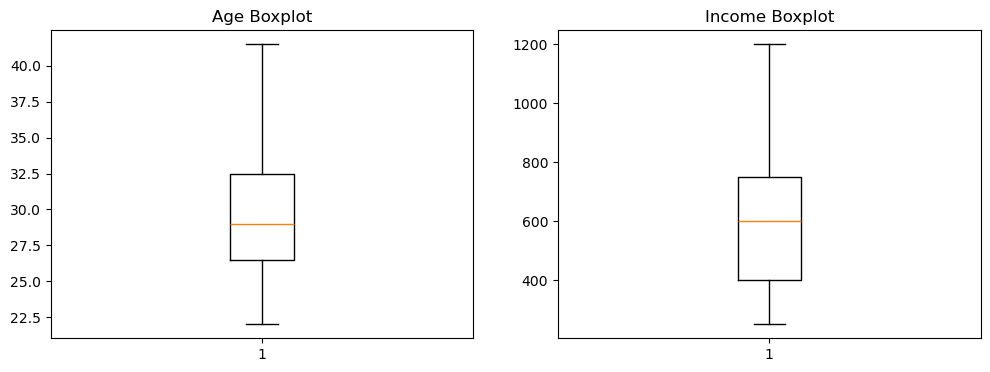

After Outlier Treatment:
    Age Gender  Income   City  Purchase_Flag
0  25.0      M     450  Tokyo              1
1  30.0      F     600  Osaka              0
2  29.0      M     800  Kyoto              1
3  35.0      F     350  Tokyo              0
4  22.0      M     250  Osaka              1
5  28.0      F     700  Kyoto              1
6  41.5      F    1200  Tokyo              0


,Age,Gender,Income,City,Purchase_Flag
0,25.0,M,450,Tokyo,1
1,30.0,F,600,Osaka,0
2,29.0,M,800,Kyoto,1
3,35.0,F,350,Tokyo,0
4,22.0,M,250,Osaka,1
5,28.0,F,700,Kyoto,1
6,41.5,F,1200,Tokyo,0


In [16]:
# Visualize outliers
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.boxplot(df['Age'].dropna())  # Added .dropna() to handle potential NaN values
plt.title('Age Boxplot')

plt.subplot(1, 2, 2)
plt.boxplot(df['Income'])
plt.title('Income Boxplot')
plt.show()

# IQR-based outlier clipping
def remove_outliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Clip outliers
    df[col] = df[col].clip(lower_bound, upper_bound)
    return df

df = remove_outliers(df, 'Age')
df = remove_outliers(df, 'Income')

print("After Outlier Treatment:")
print(df)
display(df)

## 4. Encode Categorical Variables

In [17]:
# Before One-Hot Encoding
print("Before Encoding:")
print(df[['Gender', 'City']].head())

# Using pandas get_dummies
df_encoded = pd.get_dummies(df, columns=['Gender', 'City'], drop_first=True)

print("\nAfter One-Hot Encoding:")
display(df_encoded.head())

Before Encoding:
  Gender   City
0      M  Tokyo
1      F  Osaka
2      M  Kyoto
3      F  Tokyo
4      M  Osaka

After One-Hot Encoding:


,Age,Income,Purchase_Flag,Gender_M,City_Osaka,City_Tokyo
0,25.0,450,1,True,False,True
1,30.0,600,0,False,True,False
2,29.0,800,1,True,False,False
3,35.0,350,0,False,False,True
4,22.0,250,1,True,True,False


## 5. Scale Numerical Features

In [18]:
# Standardization
scaler = StandardScaler()

# Scale Age and Income
df_encoded[['Age', 'Income']] = scaler.fit_transform(df_encoded[['Age', 'Income']])
print("After Standardization:")
display(df_encoded.head())

After Standardization:


,Age,Income,Purchase_Flag,Gender_M,City_Osaka,City_Tokyo
0,-0.846559,-0.578691,1,True,False,True
1,-0.011923,-0.072336,0,False,True,False
2,-0.178850,0.602804,1,True,False,False
3,0.822712,-0.916261,0,False,False,True
4,-1.347340,-1.253831,1,True,True,False


## 6. Efficient Preprocessing with Pipeline

In [11]:
# Separate features and target
X = df.drop('Purchase_Flag', axis=1)
y = df['Purchase_Flag']

# Define column types
numeric_features = ['Age', 'Income']
categorical_features = ['Gender', 'City']

# Build pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numeric_features),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(drop='first'))
        ]), categorical_features)
    ])

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply preprocessing
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print("Training Data Shape:", X_train_processed.shape)
print("Test Data Shape:", X_test_processed.shape)

Training Data Shape: (5, 5)
Test Data Shape: (2, 5)


## 7. Inspect Processed Data

In [12]:
# Convert processed data to DataFrame
# Get numerical feature names
num_columns = numeric_features

# Get categorical feature names from OneHotEncoder
cat_encoder = preprocessor.named_transformers_['cat'].named_steps['encoder']
cat_columns = cat_encoder.get_feature_names_out(categorical_features)

# Combine all column names
all_columns = np.concatenate([num_columns, cat_columns])

# Create DataFrame
df_train_processed = pd.DataFrame(X_train_processed, columns=all_columns)

print("Final Processed Training Data:")
display(df_train_processed.head())

Final Processed Training Data:


,Age,Income,Gender_M,City_Osaka,City_Tokyo
0,-0.467130,0.117749,0.0,0.0,0.0
1,-0.316443,0.412121,1.0,0.0,0.0
2,-1.371253,-1.206927,1.0,1.0,0.0
3,0.587680,-0.912554,0.0,0.0,1.0
4,1.567147,1.589611,0.0,0.0,1.0


## 8. Key Preprocessing Takeaways

1. **Missing Values**
   - Numerical: Impute with median
   - Categorical: Impute with mode

2. **Outliers**
   - Detect using IQR method
   - Treat by clipping or removal

3. **Categorical Variables**
   - Use One-Hot Encoding as baseline
   - Consider Target Encoding for high cardinality

4. **Numerical Features**
   - Standardize (StandardScaler) or Normalize (MinMaxScaler)

5. **Pipeline Construction**
   - Use ColumnTransformer for different processing
   - Prevent data leakage with proper fit/transform separation